# Hodgkin-Huxley model: traces+spikes inference from recordings

In [1]:
# imports
from brian2 import *
from brian2modelfitting import Inferencer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis as kurt

In [2]:
# pretty figures :3
%config InlineBackend.figure_format = 'retina'

In [3]:
# load few recorded traces
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')
inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[[0, 1], 1:]
out_traces = df_out_traces.to_numpy()
out_traces = out_traces[[0, 1], 1:]

In [4]:
# set parameters and define the Hodgkin-Huxley model
area = 20_000*um**2
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
dt = 0.01*ms
eqs = '''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
    dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
            (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
            (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
            (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    g_na : siemens (constant)
    g_kd : siemens (constant)
    gl   : siemens (constant)
    Cm   : farad (constant)
'''

In [5]:
# set up time domain
t = np.arange(0, inp_traces.shape[1]*dt/ms, dt/ms)
t_start, t_end = t[np.where(inp_traces[0, :] != 0)[0][[0, -1]]]

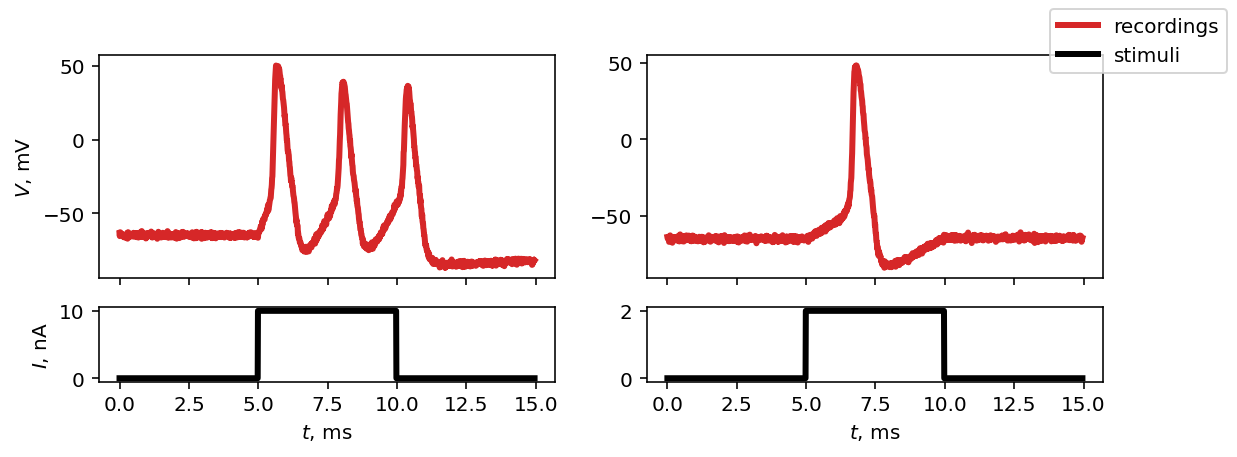

In [6]:
# visualize the recordings
nrows = 2
ncols = out_traces.shape[0]
fig, axs = subplots(nrows, ncols, sharex=True,
                    gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 3))
for idx in range(ncols):
    axs[0, idx].plot(t, out_traces[idx, :].T, lw=3, c='C3', label='recordings')
    axs[1, idx].plot(t, inp_traces[idx, :].T/nA, lw=3, c='k', label='stimuli')
    axs[1, idx].set_xlabel('$t$, ms')
    if idx == 0:
        axs[0, idx].set_ylabel('$V$, mV')
        axs[1, idx].set_ylabel('$I$, nA')
handles, labels = [(h + l) for h, l
                   in zip(axs[0, idx].get_legend_handles_labels(),
                   axs[1, idx].get_legend_handles_labels())]
fig.legend(handles, labels)
tight_layout();

In [10]:
# get spike times manually
def get_spike_times(x):
    x = x.copy()
    # put everything to -40 mV that is below -40 mV or has negative slope
    ind = np.where(x < -0.04)
    x[ind] = -0.04
    ind = np.where(np.diff(x) < 0)
    x[ind] = -0.04

    # remaining negative slopes are at spike peaks
    ind = np.where(np.diff(x) < 0)
    spike_times = np.array(t)[ind]
    
    # spike times for active stimulus
    spike_times_stim = spike_times[
        (spike_times > t_start) & (spike_times < t_end)
        ]
    
    # number of spikes
    if spike_times_stim.shape[0] > 0:
        spike_times_stim = spike_times_stim[
            np.append(1, np.diff(spike_times_stim)) > 0.5
        ]
    return spike_times_stim / 1000  # in seconds

# store spike times for each trace into the list
spike_times = [get_spike_times(out_trace) for out_trace in out_traces]

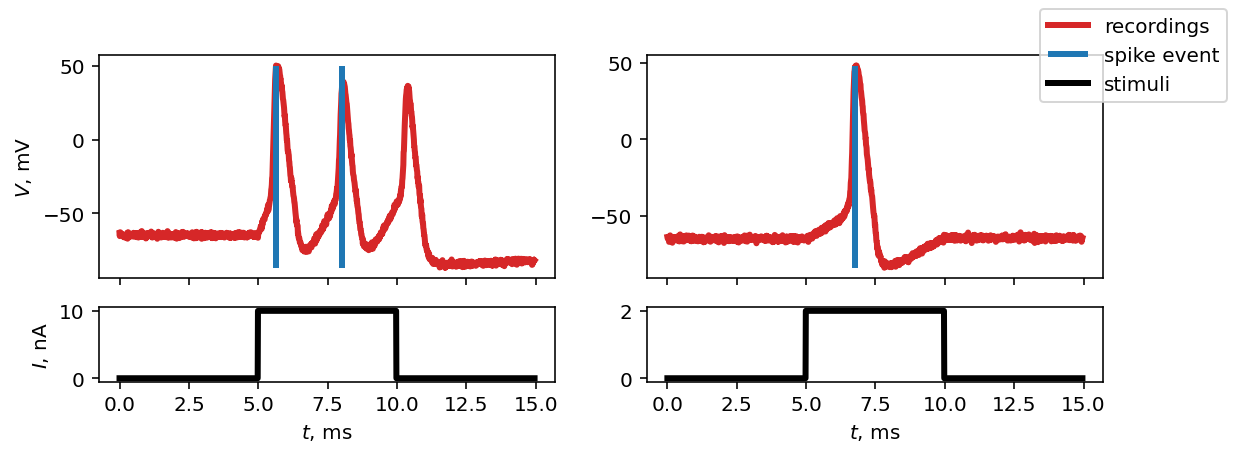

In [13]:
# visualize the recordings and spikes while stimulus is on
nrows = 2
ncols = out_traces.shape[0]
fig, axs = subplots(nrows, ncols, sharex=True,
                    gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 3))
for idx in range(ncols):
    spike_idx = np.in1d(t, spike_times[idx] * 1000).nonzero()[0]
    spike_v = (out_traces[idx, :].min(), out_traces[idx, :].max())
    axs[0, idx].plot(t, out_traces[idx, :].T, lw=3, c='C3',
                     label='recordings', zorder=1)
    axs[0, idx].vlines(t[spike_idx], *spike_v, lw=3, color='C0',
                       label='spike event', zorder=2)
    axs[1, idx].plot(t, inp_traces[idx, :].T/nA, lw=3, c='k', label='stimuli')
    axs[1, idx].set_xlabel('$t$, ms')
    if idx == 0:
        axs[0, idx].set_ylabel('$V$, mV')
        axs[1, idx].set_ylabel('$I$, nA')
handles, labels = [(h + l) for h, l
                   in zip(axs[0, idx].get_legend_handles_labels(),
                   axs[1, idx].get_legend_handles_labels())]
fig.legend(handles, labels)
tight_layout;

In [14]:
# a few features to create a summary statistics representation of traces
v_features = [
    lambda x: np.max(x[(t > t_start) & (t < t_end)]),  # max active potential
    lambda x: np.mean(x[(t > t_start) & (t < t_end)]),  # mean active potential
    lambda x: np.std(x[(t > t_start) & (t < t_end)]),  # std of active potential
    lambda x: kurt(x[(t > t_start) & (t < t_end)], fisher=False),  # kurtosis of active potential
    lambda x: np.mean(x[(t > 0.25 * t_start) & (t < 0.75 * t_start)]),  # membrane resting potential
]

s_features = [
    lambda x: x.size,  # count of spikes in the train
]

In [15]:
# inference object instantiation
inferencer = Inferencer(dt=dt, model=eqs,
                        input={'I': inp_traces*amp},
                        output={'v': out_traces*mV,
                                'spikes': spike_times},
                        features={'v': v_features,
                                  'spikes': s_features},
                        method='exponential_euler',
                        threshold='m > 0.5',
                        refractory='m > 0.5',
                        param_init={'v': 'VT'})

In [16]:
# posterior estimation
posterior = inferencer.infer(n_samples=5_000,
                             n_rounds=3,
                             inference_method='SNPE',
                             density_estimator_model='mdn',
                             restart=True,
                             gl=[1e-09*siemens, 1e-07*siemens],
                             g_na=[2e-06*siemens, 2e-04*siemens],
                             g_kd=[6e-07*siemens, 6e-05*siemens],
                             Cm=[0.1*uF*cm**-2*area, 2*uF*cm**-2*area])

Extracting features:   0%|          | 0/2 [00:00<?, ?it/s]

3-round focused inference:   0%|          | 0/3 [00:00<?, ?it/s]

Neural network successfully converged after 197 epochs.
Neural network successfully converged after 217 epochs.
Neural network successfully converged after 23 epochs.


In [17]:
# sampling the posterior
samples = inferencer.sample((5_000, ))

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the remaining
                        4998 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.


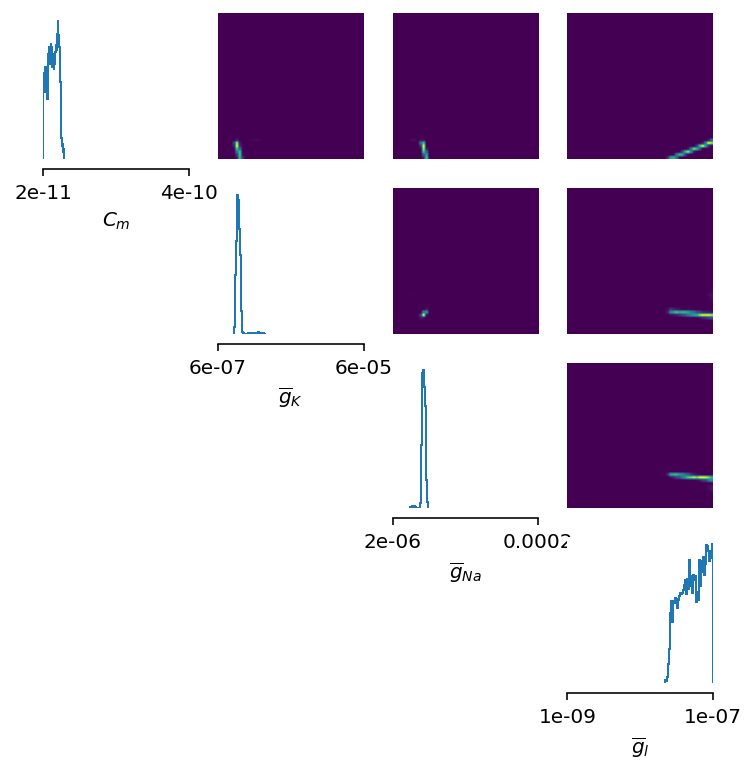

In [18]:
# pairplotting space of sampled parameters from posterior
limits = {'gl': [1e-9*siemens, 1e-07*siemens],
          'g_na': [2e-06*siemens, 2e-04*siemens],
          'g_kd': [6e-07*siemens, 6e-05*siemens],
          'Cm': [0.1*uF*cm**-2*area, 2*uF*cm**-2*area]}
labels = {'gl': r'$\overline{g}_{l}$',
          'g_na': r'$\overline{g}_{Na}$',
          'g_kd': r'$\overline{g}_{K}$',
          'Cm': r'$C_{m}$'}

inferencer.pairplot(limits=limits,
                    labels=labels,
                    ticks=limits,
                    figsize=(6, 6));

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the remaining
                        -2 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.
                        constant for `log_prob()`. However, only 0%
                        posterior samples are within the prior support. It may take a
                        long time to collect the remaining 9996 samples.
                        Consider interrupting (Ctrl-C) and either basing the estimate
                        of the normalizing constant on fewer samples (by calling
                        `posterior.leakage_correction(x_o, num_rejection_samples=N)`,
                        where `N` is the number of samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will result
   

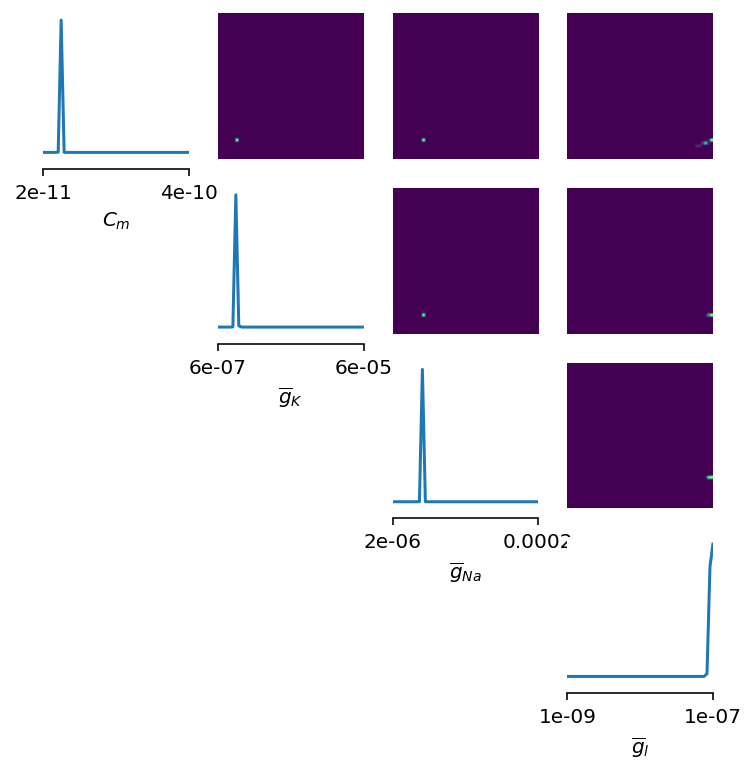

In [19]:
# conditional pairplot
condition = inferencer.sample((1, ))
inferencer.conditional_pairplot(condition=condition,
                                limits=limits,
                                labels=labels,
                                ticks=limits,
                                figsize=(6, 6));

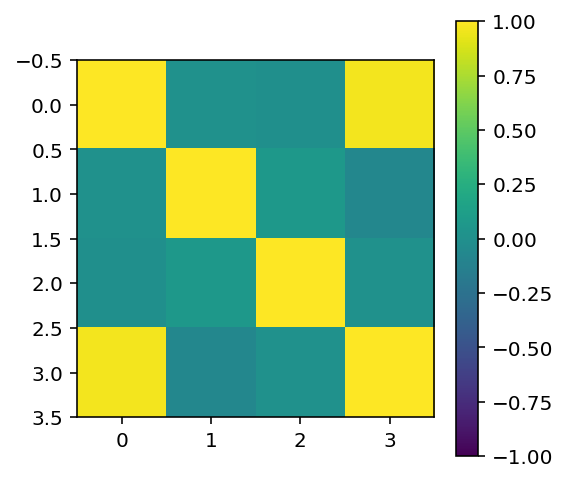

In [20]:
# computing conditional coefficient matrix using the same condition
cond_coeff_mat = inferencer.conditional_corrcoeff(condition=condition, limits=limits)

fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1])
_ = fig.colorbar(im)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the remaining
                        -3 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.


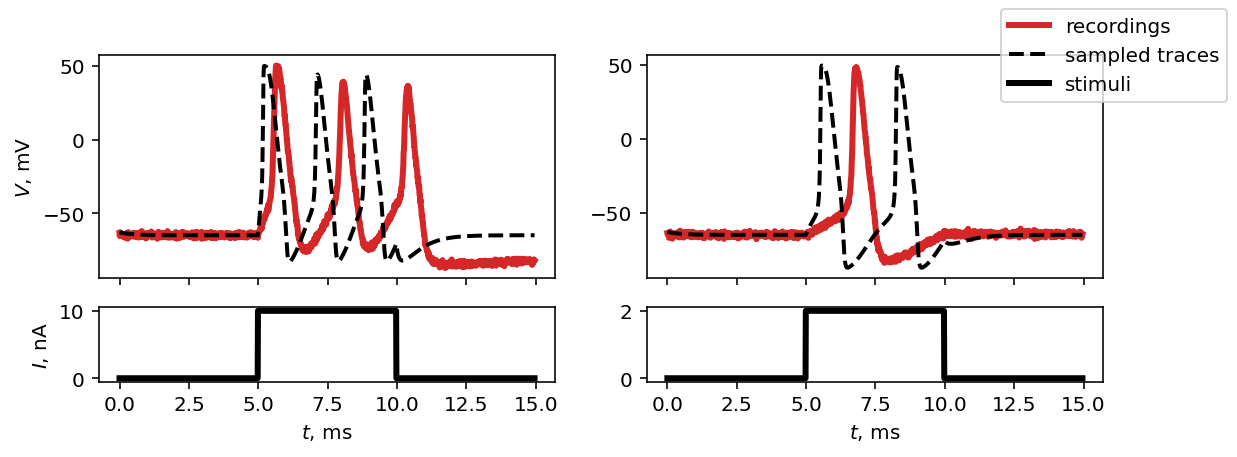

In [21]:
# generate traces from a single sample of parameters
inf_traces = inferencer.generate_traces(output_var='v')

nrows = 2
ncols = out_traces.shape[0]
fig, axs = subplots(nrows, ncols, sharex=True,
                    gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 3))
for idx in range(ncols):
    spike_idx = np.in1d(t, spike_times[idx]).nonzero()[0]
    spike_v = (out_traces[idx, :].min(), out_traces[idx, :].max())
    axs[0, idx].plot(t, out_traces[idx, :].T, 'C3-', lw=3, label='recordings')
    axs[0, idx].plot(t, inf_traces[idx, :].T/mV, 'k--', lw=2,
                     label='sampled traces')
    axs[1, idx].plot(t, inp_traces[idx, :].T/nA, lw=3, c='k', label='stimuli')
    axs[1, idx].set_xlabel('$t$, ms')
    if idx == 0:
        axs[0, idx].set_ylabel('$V$, mV')
        axs[1, idx].set_ylabel('$I$, nA')
handles, labels = [(h + l) for h, l
                   in zip(axs[0, idx].get_legend_handles_labels(),
                   axs[1, idx].get_legend_handles_labels())]
fig.legend(handles, labels)
tight_layout;

# Integrate-and-Fire model: spike inference from synthetic trace

In [1]:
from brian2 import *
from brian2modelfitting import Inferencer
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# set parameters
dt = 0.1*ms
defaultclock.dt = dt
El = -70*mV
VT = -50*mV
DeltaT = 2*mV
ground_truth_params = {'gl': 30*nS, 'C': 1*nF}

In [4]:
# set input trace
inp_trace = np.hstack([np.zeros(int(round(5*ms/dt))),
                       np.ones(int(round(25*ms/dt))),
                       np.zeros(int(round(30*ms/dt)))]) * 10*nA
I = TimedArray(inp_trace, dt=dt)

In [5]:
# set the model equations
eqs = '''
    dv/dt = (gl*(El - v) + gl*DeltaT*exp((v - VT) / DeltaT) + I(t)) / C : volt
    gl    : siemens (constant)
    C     : farad (constant)
    '''

In [6]:
# compute traces and spike trains
neurons = NeuronGroup(1, eqs,
                      threshold='v > -50*mV',
                      reset='v = -70*mV',
                      method='exponential_euler')
neurons.v = -70*mV
neurons.set_states(ground_truth_params)
monitor = StateMonitor(neurons, 'v', record=True)
smonitor = SpikeMonitor(neurons, record=True)
run(60*ms)
out_trace = monitor.v
spike_times = array(smonitor.t_)

In [7]:
# inference procedure
start_scope()
El = -70*mV
VT = -50*mV
DeltaT = 2*mV
eqs_inf = '''
    dv/dt = (gl*(El - v) + gl*DeltaT*exp((v - VT) / DeltaT) + I_syn) / C : volt
    gl    : siemens (constant)
    C     : farad (constant)
    '''

features = [
    lambda x: x.size,  # number of spikes
    lambda x: 0. if np.diff(x).size == 0 else np.mean(np.diff(x)),  # mean inter-spike interval
    ]

inferencer = Inferencer(dt=dt, model=eqs_inf,
                        input={'I_syn': inp_trace.reshape(1, -1)},
                        output={'spikes': [spike_times]},
                        features={'spikes': features},
                        method='exponential_euler',
                        threshold='v > -50*mV',
                        reset='v = -70*mV',
                        param_init={'v': -70*mV})

In [8]:
# train the inferencer
posterior = inferencer.infer(n_samples=1_000,
                             n_rounds=3,
                             gl=[10*nS, 100*nS],
                             C=[0.1*nF, 10*nF])

The state monitor object is not defined.


Extracting features:   0%|          | 0/1 [00:00<?, ?it/s]

3-round focused inference:   0%|          | 0/3 [00:00<?, ?it/s]

Neural network successfully converged after 120 epochs.
Neural network successfully converged after 49 epochs.
Neural network successfully converged after 47 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

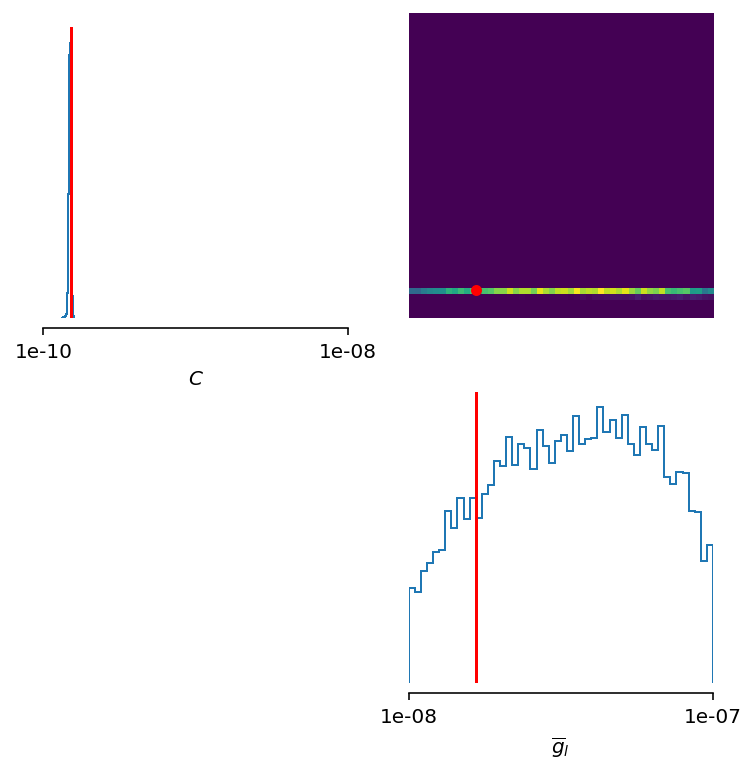

In [9]:
# sample and pairplot
samples = inferencer.sample((7_000, ))
labels = {'gl': r'$\overline{g}_{l}$', 'C': r'$C$'}
ticks = {'gl': [10*nS, 100*nS], 'C': [0.1*nF, 10*nF]}
inferencer.pairplot(labels=labels,
                    limits=ticks,
                    ticks=ticks,
                    points=ground_truth_params,
                    points_offdiag={'markersize': 9},
                    points_colors=['r'], 
                    figsize=(6, 6));

In [9]:
# set up time domain
t = np.arange(0, inp_trace.size*dt/ms, dt/ms)
t_start, t_end = t[np.where(inp_trace != 0)[0][[0, -1]]]

In [17]:
# identify spike events
spike_v = (out_trace.min()/mV, out_trace.max()/mV)
spike_idx = []
for spike_time in spike_times:
    spike_idx.append(np.where(np.isclose(spike_time * 1000, t))[0].item())

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

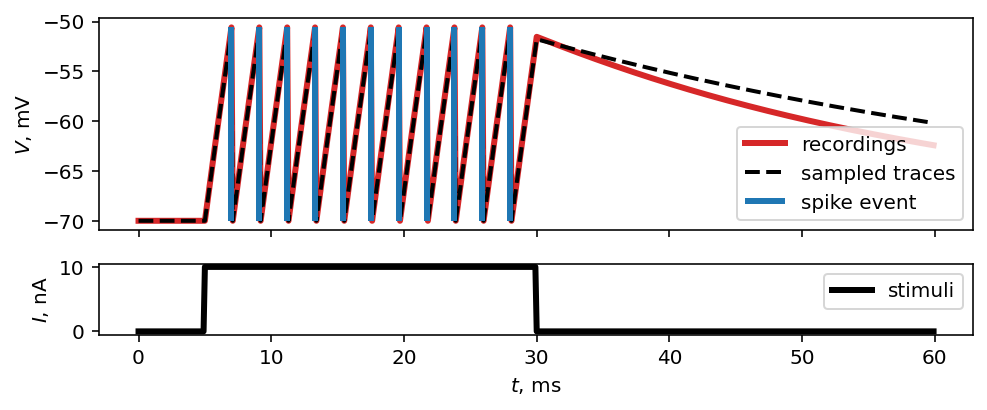

In [26]:
# generate traces from a single sample of parameters
inf_trace = inferencer.generate_traces(output_var='v')

nrows = 2
fig, axs = subplots(nrows, 1, sharex=True,
                    gridspec_kw={'height_ratios': [3, 1]}, figsize=(7, 3))
axs[0].plot(t, out_trace.T/mV, 'C3-', lw=3, label='recordings')
axs[0].plot(t, inf_trace.T/mV, 'k--', lw=2, label='sampled traces')
axs[0].vlines(t[spike_idx], *spike_v, lw=3, color='C0', label='spike event', zorder=3)
axs[0].set_ylabel('$V$, mV')
axs[0].legend()
axs[1].plot(t, inp_trace.T/nA, lw=3, c='k', label='stimuli')
axs[1].set_xlabel('$t$, ms')
axs[1].set_ylabel('$I$, nA')
axs[1].legend()
tight_layout();